<center>
<img src="https://tensorflowkorea.files.wordpress.com/2020/12/4.-e18492e185a9e186abe1848ce185a1-e18480e185a9e186bce18487e185aee18492e185a1e18482e185b3e186ab-e18486e185a5e18489e185b5e186abe18485e185a5e18482e185b5e186bce18483e185b5e186b8e18485e185a5e.png?w=972" width="200" height="200"><br>
</center>

## 07-3 신경망 모델 훈련

이번 절에서는 케라스 API를 사용해 모델을 훈련하는데 필요한 다양한 도구들을 알아보자. 이 과정에서 여러가지 중요한 개념과 모범 사례를 함께 살펴보자.

### - 손실 곡선

2절에서 fit() 메서드로 모델을 훈련하면 훈련 과정이 상세하게 출력되어 확인할 수 있었다. 여기에는 에포트 횟수, 손실, 정확도 등이 있었다. 그런데 아래와 같이 출력의 마지막에 다음과 같은 메시지를 본 기억이 있을 것이다.

<tensorflow.python.keras.callbacks.History at 0x7f11f82f5710>

노트북의 코드 셀은 print() 명령을 사용하지 않더라도 마지막 라인의 실행 결과를 자동으로 출력한다. 즉 이 메세지는 fit() 메서드의 실행 결과를 출력한 것이다. 다시 말해 fit() 메서드가 무엇인가 반환한다는 증거이다. 사실 케라스의 fit() 메서드는 History 클래스 객체를 반환한다. History 객체에는 훈련 과정에서 계산한 지표, 즉 손실과 정확도 값이 저장되어 있다. 이 값을 사용하면 그래프를 그릴 수 있을 것이다.

먼저 이전 절에서 사용했던 것과 같이 패션 MNIST 데이터셋을 적재하고 훈련 세트와 검증 세트로 나눈다.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

/home/jaeyoon89/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jaeyoon89/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jaeyoon89/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jaeyoon89/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

그 다음 모델을 만들자. 이전 절과는 다르게 모델을 만드는 간단한 함수를 정의하겠다. 이 함수는 하나의 매개변수를 가진다. 먼저 코드를 작성해 보자.

In [2]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

if구문을 제외하면 이 코드는 이전 절에서 만든 것과 동일한 모델을 만든다. if 구문의 역할은 model_fn() 함수에 (a_layer 매개변수로) 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 것이다. 마치 프로그래밍과 비슷하다.

여기서는 a_layer 매개변수로 층을 추가하지 않고 단순하게 model_fn() 함수를 호출한다. 그리고 모델 구조를 출력하면 이전 절과 동일한 모델이라는 것을 확인할 수 있다.

In [3]:
model = model_fn()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


이전 절과 동일하게 모델을 훈련하지만 fit() 메서드의 결과를 history 변수에 담아보자.

In [4]:
model.compile(optimizer = 'rmsprop',loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)  # verbose 0은 훈련 과정 막대 안나오게 하는 매개변수

history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어 있다. 이 딕셔너리에 어떤 값이 있는지 확인해 보자.

In [5]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


손실과 정확도가 포함되어 있다. 이전 절에서 언급했듯 케라스는 기본적으로 에포크마다 손실을 계산한다. 정확도는 compile() 메서드에서 metrics 매개변수에 accuracy를 추가했기 때문에 history 속성에 포함되어 있다.

history 속성에 포함된 손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트이다. matplotlib을 사용해 그래프로 그려보자.

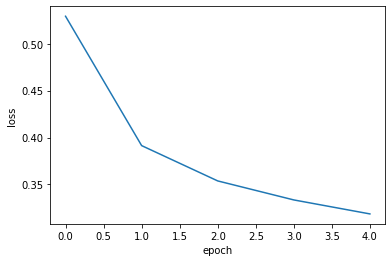

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

파이썬 리스트의 인덱스는 0부터 시작하므로 5개의 에포크가 0에서부터 4까지 x축에 표현된다. y축은 계산된 손실값이다.

이번엔 정확도를 출력해보자.

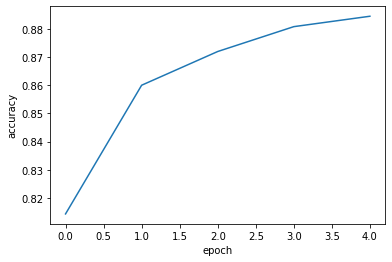

In [7]:
plt.plot(history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

에포크마다 손실이 감소하고 정확도가 향상된다. 그렇다면 에포크를 늘려서 더 훈련을 하면 손실이 감소할까? 이번엔 에포크 횟수를 20으로 늘려 모델을 훈련하고 손실 그래프를 그려보자.

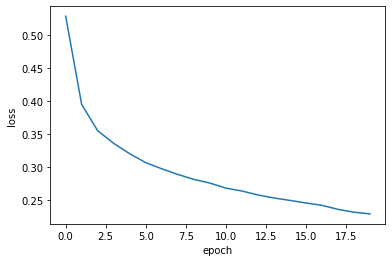

In [8]:
model = model_fn()
model.compile(optimizer = 'rmsprop',loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

예상대로 손실이 잘 감소한다.

### - 검증 손실

앞서 확률적 경사 하강법을 사용했을 때 과대/과소적합과 에포크 사이의 관계를 알아 보았다. 인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 동일한 개념이 여기에도 적용된다. 에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수 뿐만 아니라 검증 세트에 대한 점수도 필요하다. 따라서 앞에서처럼 훈련 세트의 손실만 그려서는 안된다. 4장에서는 정확도를 사용하여 과대/과소 적합을 설명했지만 이 장에서는 손실을 사용하여 과대/과소적합을 다루어 보자.

에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit() 메서드에 검증 데이터를 전달할 수 있다. 다음처럼 validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달한다.

In [9]:
model = model_fn()
model.compile(optimizer = 'rmsprop',loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

반환된 history.history 딕셔너리에 어떤 값이 들어 있는지 키를 확인해 보자.

In [10]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


검증 세트에 대한 손실은 val_loss에 들어 있고 정확도는 val_acc에 들어있을 것이다. 과대/과소적합 문제를 조사하기 위해 훈련 손실과 검증 손실을 한 그래프에 그려서 비교해 보자.

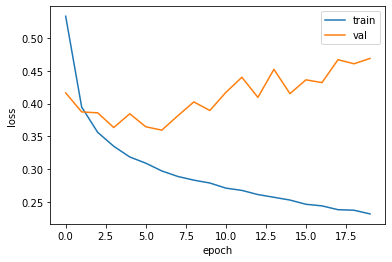

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

초기에 검증 손실이 감소하다가 다섯 번째 에포크 만에 다시 상승하기 시작한다. 훈련 손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어 진다. 검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다.

과대 적합을 막기 위해 3장에서 배웠던 규제 방식 대신에 신경망에 특화된 규제 방법을 다음 섹션에서 다루어 보자. 지금은 옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화시킬 수 있는지 알아보자. 기본 RMSprop 대신 Adam 을 선택하여 학습해보자.

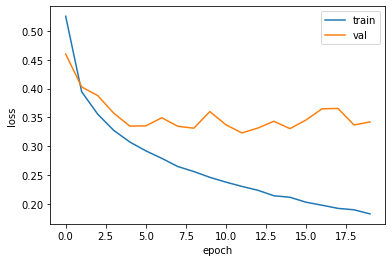

In [12]:
model = model_fn()
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

과대적합이 훨씬 줄었다. 검증 손실 그래프에 여전히 요동이 남아있지만 열 번째 에포크까지 전반적인 감소 추세가 이어지고 있다. 이는 Adam 옵티마이저가 이 데이터셋에 잘 맞는다는 것을 보여준다.

### - 드롭아웃

드롭아웃은 딥러닝의 아버지로 불리는 제프리 힌턴이 소개했다. 이 방식은 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 과대적합을 막는다. 뉴런은 랜덤하게 드롭아웃 되고 얼마나 많은 뉴런을 드랍할지는 우리가 정해야 할 또 다른 하이퍼파라미터이다. 

드롭아웃이 왜 과대적합을 막을까? 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 대해 주의를 기울여야 한다. 일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 더 안정적인 예측을 만들 수 있다.

케라스에서는 드롭아웃을 keras.layers 패키지 아래 Dropout 클래스를 제공한다. 어떤 층의 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로 만드는 것이다. 드롭아웃이 층처럼 사용되지만 훈련되는 모델 파라미터는 없다. 그럼 앞서 정의한 model_fn() 함수에 드롭아웃 객체를 전달하여 층을 추가해 보자. 여기에서는 30% 정도를 드롭아웃 해보자.

In [13]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


출력 결과에서 볼 수 있듯 은닉층 뒤에 추가된 드롭아웃 층은 훈련되는 모델 파라미터가 없다. 또한 입력과 출력의 크기가 같다. 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않는다.

물론 훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야 한다. 훈련된 모든 뉴런을 사용해야 올바른 예측을 수행할 수 있다. 그렇다면 모델을 훈련한 다음 층을 다시 빼야 할까? 똑똑하게도 텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃을 적용하지 않는다. 그래서 마음 편하게 검증 점수를 계산할 수 있다. 이전과 마찬가지로 훈련 손실과 검증 손실의 그래프를 그려 비교해 보자.

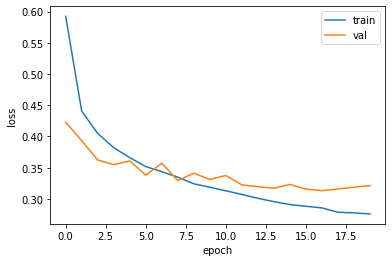

In [14]:
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

과대적합이 확실히 줄었다. 열 번째 에포크 정도에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느 정도 유지되고 있다. 이 모델은 20번의 에포크 동안 훈련했기 때문에 결국 다소 과대적합 되어있다. 그렇다면 과대적합 되지 않은 모델을 얻기 위해 에포크 횟수를 10으로 하고 다시 훈련해 보아야 할 듯 하다.

### - 모델 저장과 복원

에포크 횟수를 10으로 다시 지정하고 모델을 훈련하자. 그리고 이 모델을 저장해보자.

In [16]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

케라스 모델은 훈련된 모델의 파라미터를 저장하는 save() 메서드도 제공한다. 기본적으로 이 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [24]:
model.save_weights('model-weights.h5')

또한 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공한다. 기본적으로 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [25]:
model.save('model-whole.h5')

이제 이 두파일이잘 만들어 졌는지 확인해 보자.

In [26]:
!ls -al *.h5

-rw-r--r-- 1 jaeyoon89 jaeyoon89 332672 May 26 17:15 model-weights.h5
-rw-r--r-- 1 jaeyoon89 jaeyoon89 334008 May 26 17:15 model-whole.h5


In [31]:
model = model_fn(keras.layers.Dropout(0.3))

이 모델의 검증 정확도를 확인해 보자. 케라스에서 예측을 수행하는 predict() 메서드는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환한다. 패션 MNIST 데이터셋이 다중 분류 문제이기 때문이다.

In [34]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.10558333333333333


모델의 predict() 메서드 결과에서 가장 큰 값을 고르기 위해 넘파이 argmax() 함수를 사용했다. 이 함수는 배열에서 가장 큰 값의 인덱스를 반환한다. 예를 들어 배열의 첫 번째 원소가 가장 큰 값을 경우 0을 반환한다. 다행히 우리가 준비한 타깃값도 0부터 시작하기 때문에 비교하기 좋다.


### - 콜백

콜백은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들이다.fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다. 여기서 사용할ModelCheckpoint 콜백은 기본적으로 최상의 검증 점수를 만다는 모델을 저장한다. 저장될 파일 이름을 'best-model.h5'로 지정하여 콜백을 적용해 보자.

In [37]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

앞에 함수를 만드는 것은 이전과 동일한다. ModelCheckpoint 클래스의 객체 checkpoint_cb를 만든 후 fit() 메서드의 callbacks 매개변수에 리스트로 감싸서 전달한다.

사실 검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없다. 이때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있다. 이렇게 과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 조기 종료라고 부르며, 딥러닝 분야에서 널리 사용된다.
조기종료는 훈련 에포크 횟수를 제한하는 역할이지만 모델이 과대적합 되는 것을 막아 주기 때문에 규제 방법 중 하나로 생각할 수도 있다.

케라스에는 조기 종료를 위한 EarlyStopping 콜백을 제공한다. 이 콜백의 patience 매개변수는 검증 점수가 향상 되지 않더라도 참을 에포크 횟수로 지정한다. EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다. 또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.

In [40]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history= model.fit(train_scaled, train_target, epochs=20, verbose=0,
                  validation_data=(val_scaled, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

fit() 메서드에 callbacks 매개변수 2개의 콜백을 리스트로 전달하였다. 훈련을 마치고 나면 몇 번째 에포크에서 훈련이 중지되었는지 early_stopping_cb 객체의 stopped_epoch 속성에서 확인할 수 있다.

In [41]:
print(early_stopping_cb.stopped_epoch)

12


에포크 횟수가 0부터 시작하기 때문에 12는 열세 번째 에포크에서 훈련이 중지되었다는 것을 의미한다. patience를 2로 지정했으므로 최상의 모델은 열한 번째 에포크일 것이다.

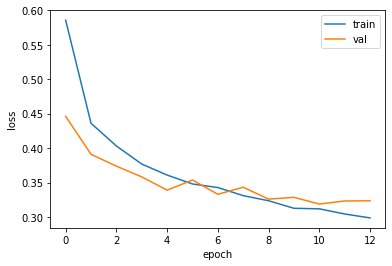

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-07', dpi=300)
plt.show()

위 그래프에서 보다시피 열한 번째 에포크에서 가장 낮은 손실을 기록했고 열세 번째 에포크에서 훈련이 중지 되었다. 조기 종료 기법을 사용하면 안심하고 에포크 횟수를 크게 지정해도 괜찮다.

마지막으로 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능을 확인해 보자.

In [44]:
model.evaluate(val_scaled, val_target)

12000/12000 [==============================] - 0s 21us/sample - loss: 0.3188 - acc: 0.8837


[0.3187801432410876, 0.8836667]

출처 : 혼자 공부하는 머신러닝 + 딥러닝